# 物件偵測專班

# YOLOv4 預測教學

## 匯入所需套件

In [ ]:
!pip install wandb PyYAML==5.4.1 opencv-python==4.4.0.46 imgaug==0.2.5 -q

     |████████████████████████████████| 1.7 MB 4.4 MB/s 
     |████████████████████████████████| 636 kB 37.5 MB/s 
     |████████████████████████████████| 49.5 MB 193 kB/s 
     |████████████████████████████████| 562 kB 49.7 MB/s 
     |████████████████████████████████| 144 kB 42.6 MB/s 
     |████████████████████████████████| 181 kB 33.6 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 


In [ ]:
!git clone https://github.com/d246810g2000/PyTorch_YOLOv4.git

Cloning into 'PyTorch_YOLOv4'...
remote: Enumerating objects: 810, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 810 (delta 64), reused 126 (delta 35), pack-reused 648
Receiving objects: 100% (810/810), 32.93 MiB | 12.92 MiB/s, done.
Resolving deltas: 100% (417/417), done.


In [ ]:
%cd /content/PyTorch_YOLOv4/

/content/PyTorch_YOLOv4


In [ ]:
import os
import shutil
import time
import yaml
from pathlib import Path

import cv2
import torch
import torch.backends.cudnn as cudnn
from numpy import random
import matplotlib.pyplot as plt

from utils.google_utils import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import (
    check_img_size, non_max_suppression, apply_classifier, scale_coords, xyxy2xywh, strip_optimizer)
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized

from models.models import *
from utils.datasets import *
from utils.general import *
%matplotlib inline  

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 參數設置

In [ ]:
weights = 'best.pt'
source = 'cat.jpg'
out = 'inference/output'
cfg = 'cfg/yolov4-pet.cfg'
data = 'data/pet.yaml'
imgsz = 640
conf_thres = 0.3
iou_thres = 0.5

In [ ]:
# 創建資料夾
if os.path.exists(out):
    shutil.rmtree(out)  # delete output folder
os.makedirs(out)  # make new output folder

## 創建 yaml 和 cfg 檔

In [ ]:
!echo -e 'train: datasets/pet/train/images\nval: datasets/pet/valid/images\n\nnc: 2\nnames: [cat, dog]' > data/pet.yaml
!head data/pet.yaml

train: datasets/pet/train/images
val: datasets/pet/valid/images

nc: 2
names: [cat, dog]


In [ ]:
!cp cfg/yolov4.cfg cfg/yolov4-pet.cfg
!sed -n -e 959p -e 966p -e 1046p -e 1053p -e 1133p -e 1140p cfg/yolov4-pet.cfg

filters=255
classes=80
filters=255
classes=80
filters=255
classes=80


In [ ]:
!sed -i '959s/255/21/' cfg/yolov4-pet.cfg # (classes + 5)x3
!sed -i '966s/80/2/' cfg/yolov4-pet.cfg
!sed -i '1046s/255/21/' cfg/yolov4-pet.cfg # (classes + 5)x3
!sed -i '1053s/80/2/' cfg/yolov4-pet.cfg
!sed -i '1133s/255/21/' cfg/yolov4-pet.cfg # (classes + 5)x3
!sed -i '1140s/80/2/' cfg/yolov4-pet.cfg

In [ ]:
!sed -n -e 959p -e 966p -e 1046p -e 1053p -e 1133p -e 1140p cfg/yolov4-pet.cfg

filters=21
classes=2
filters=21
classes=2
filters=21
classes=2


## 使用 wandb 將訓練好的權重存到 local 端並讀入到模型中

In [ ]:
import wandb
user = 'd246810g2000' # 填入你的填入你的 user name
project = 'YOLOv4' # 填入你的 project name
id = '2pstmt6k' # 填入 wandb 的 id
best_model = wandb.restore('best.pt', run_path=f"{user}/{project}/{id}")

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
model = Darknet(cfg, imgsz).to(device).eval()
model.load_state_dict(torch.load(weights, map_location=device)['model'])

<All keys matched successfully>

## 預測影像

In [ ]:
dataset = LoadImages(source, img_size=imgsz, auto_size=32)

In [ ]:
def load_classes(path):
    # Loads *.yaml file at 'path'
    with open(path) as f:
        data_dict = yaml.load(f, Loader=yaml.FullLoader)  
    return data_dict['names']
    
# Get names and colors
names = load_classes(data)
colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(len(names))]

In [ ]:
# Run inference
with torch.no_grad():
    t0 = time.time()
    img = torch.zeros((1, 3, imgsz, imgsz), device=device)  # init img
    _ = model(img) # run once
    for path, img, im0s, vid_cap in dataset:
        img = torch.from_numpy(img).to(device)
        img = img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)
        # Inference
        t1 = time_synchronized()
        pred = model(img)[0]

        # Apply NMS
        pred = non_max_suppression(pred, conf_thres, iou_thres)
        t2 = time_synchronized()

        # Process detections
        for i, det in enumerate(pred):  # detections per image
            p, s, im0 = path, '', im0s
            save_path = str(Path(out) / Path(p).name)
            s += '%gx%g ' % img.shape[2:]  # print string
            gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
            if det is not None and len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

                # Print results
                for c in det[:, -1].unique():
                    n = (det[:, -1] == c).sum()  # detections per class
                    s += '%g %ss, ' % (n, names[int(c)])  # add to string

                # Write results
                for *xyxy, conf, cls in det:
                    label = '%s %.2f' % (names[int(cls)], conf)
                    plot_one_box(xyxy, im0, label=label, color=colors[int(cls)], line_thickness=1)

            # Print time (inference + NMS)
            print('%sDone. (%.3fs)' % (s, t2 - t1))
            cv2.imwrite(save_path, im0)
    print('Results saved to %s' % Path(out))
    print('Done. (%.3fs)' % (time.time() - t0))

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


image 1/1 /content/PyTorch_YOLOv4/cat.jpg: 448x640 1 cats, Done. (0.185s)
Results saved to inference/output
Done. (0.619s)


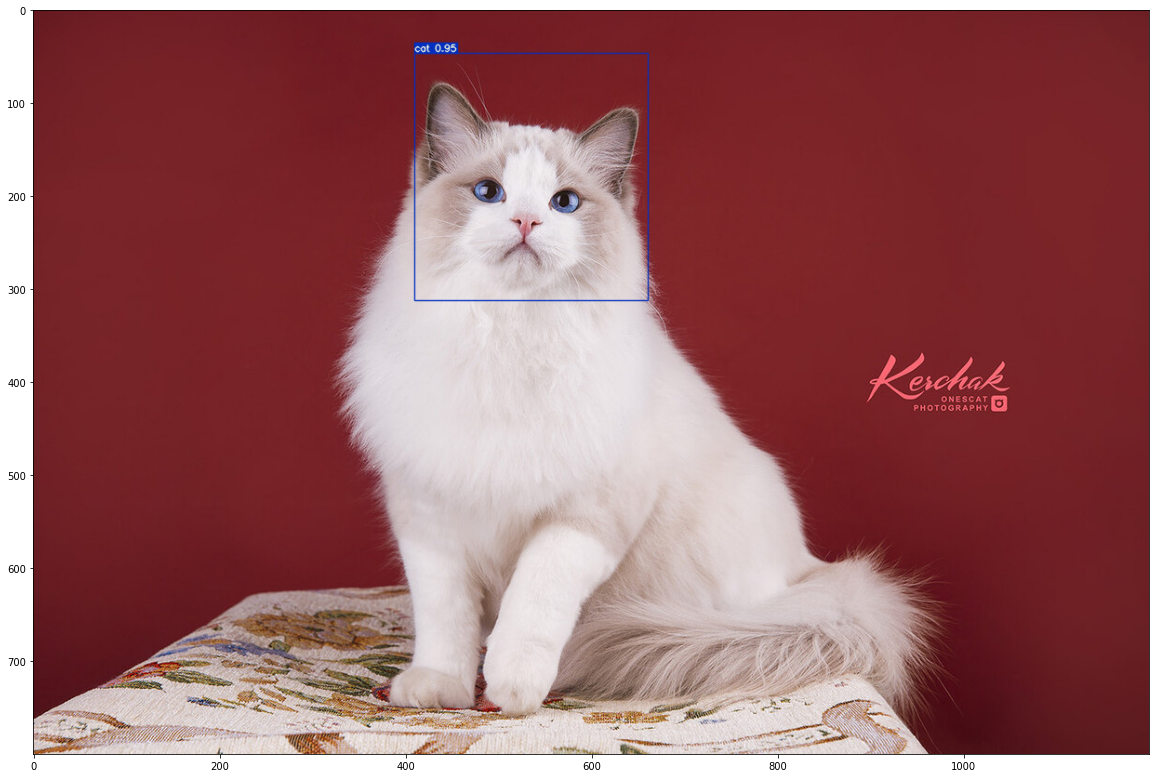

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(im0[:,:,::-1])